In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import os
import sys
sys.path.append('../../scripts')
import landcover_definitions as lc
import util


In [5]:
torchgeo_pred_dir = '../../../torchgeo_predictions_rep'
torchgeo_data_dir = '/torchgeo_data'

In [6]:
def reindex_cc(array_in):
    impervious_idxs_highres_orig = [4,5,6]
    impervious_idx_condensed = 4
    
    reindexed_array = array_in.copy()
    for c_idx in impervious_idxs_highres_orig:
        reindexed_array[array_in == c_idx] = impervious_idx_condensed
            
    return reindexed_array - 1

ny+pa
20


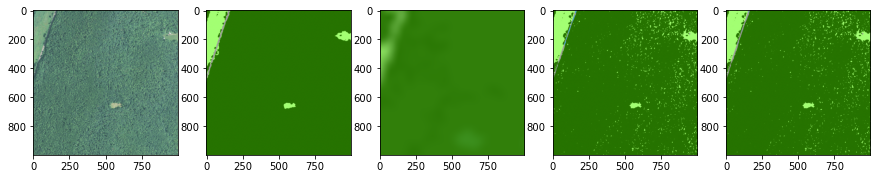

20


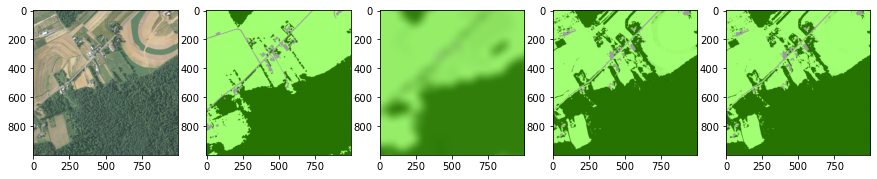

20


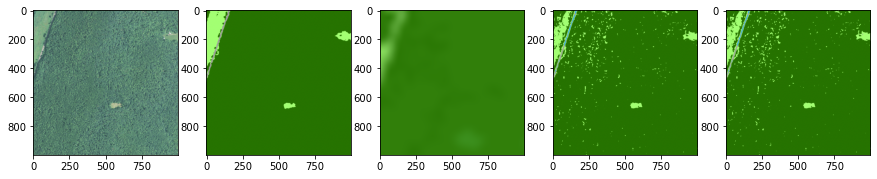

20


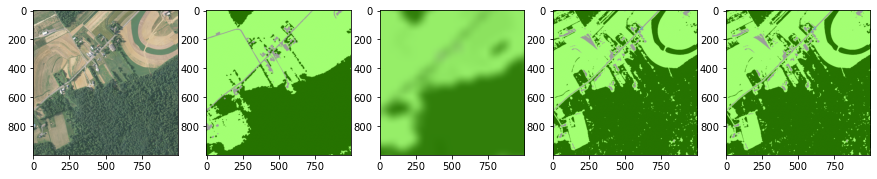

In [7]:
set_this = 'test'
compute_r = True

states_to_eval = [#'ny'
                   # , 'pa', 
                  'ny+pa'
                 ]

loss_to_eval_options = ['qr_forward', 'qr_reverse'
                       ]

prior_version = 'from_cooccurrences_101_31_no_osm_no_buildings'
prior_name = f'prior_{prior_version}'
p_add_smooth = 1e-4
lc_type = 'chesapeake_4_no_zeros'

for state_str in states_to_eval:
    print(state_str)

    for loss in loss_to_eval_options:
        data_dir = f'{torchgeo_data_dir}/cvpr_chesapeake_landcover'
        
        
        run_name = f'{state_str}_fcn_0.0001_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001/'
        
        pred_dir = f'{torchgeo_pred_dir}/{run_name}/cvpr_chesapeake_landcover'
        
        for state in state_str.split('+'):
            state_identifier = f'{state}_1m_2013_extended-debuffered-test_tiles'
            data_dir_this_set = os.path.join(data_dir,state_identifier)
            pred_dir_this_set = os.path.join(pred_dir,state_identifier)
        
            fns = os.listdir(data_dir_this_set)
            tile_ids = np.unique([x[:17] for x in fns])
            print(len(tile_ids))

            for tile_id in tile_ids[:1]:
            #or tile_id in tile_ids[:1]:
                fn_this = os.path.join(data_dir_this_set, f'{tile_id}_lc.tif')
                pred_fn_this = os.path.join(pred_dir_this_set, f'{tile_id}_{loss}_pred_last.tif')
                t1 = time.time()


                # gather the data
                with rasterio.open(fn_this.replace('lc', 'naip-new')) as f:
                    img_this = f.read()
                with rasterio.open(fn_this) as f:
                    hr_lc = f.read()[0]
                # don't need to reindex hr_lc for chesapekae
                hr_lc = reindex_cc(hr_lc)
                preds_this_soft = rasterio.open(pred_fn_this).read()

                # now do r
                if compute_r:
                    prior_this = rasterio.open(fn_this.replace('lc.tif',f'{prior_name}.tif')).read()
                    # first normalize
                    prior = prior_this / prior_this.sum(axis=0)
                    # now add smoothing and renormalize 
                    prior = (prior + p_add_smooth) / (prior + p_add_smooth).sum(axis=0)

                    z = (preds_this_soft.T / preds_this_soft.sum(axis=(1,2)) ).T
                    preds_r_soft = (prior*z)/(prior*z).sum(axis=0)

                    h1, h2 = 1000,2000
                    w1,w2 = 1000,2000
                    fig, ax = plt.subplots(1,5,figsize=(15,3))
                    ax[0].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
                    ax[1].imshow(lc.vis_lc(hr_lc[h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    ax[2].imshow(lc.vis_lc(prior[:,h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    ax[3].imshow(lc.vis_lc(preds_this_soft[:,h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    ax[4].imshow(lc.vis_lc(preds_r_soft[:,h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    plt.show()

                else:
                    h1, h2 = 0,1000,2000
                    w1,w2 = 1000,2000
                    fig, ax = plt.subplots(1,3,figsize=(15,3))
                    ax[0].imshow(img_this[:3,h1:h2,w1:w2].T.swapaxes(0,1))
                    ax[1].imshow(lc.vis_lc(hr_lc[h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    ax[2].imshow(lc.vis_lc(preds_this_soft[:,h1:h2,w1:w2], lc_type).T.swapaxes(0,1))
                    plt.show()